In [3]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
df_raw=pd.read_csv('competition_data_2023_09_25.csv')

In [ ]:
class DPmodel:
    def __init__(self, df_raw):
        self.df_raw = df_raw
        self.prods = {x for x in df_raw['sku'] if x == x}
        self.x_columns = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'comp_data_min_price', 'comp_data_max_price']

    def preprocess(self, prod_name):
        df_prod = self.df_raw[self.df_raw['sku'] == prod_name]
        self.l=df_prod.iloc[0]['min_price']
        self.u=df_prod.iloc[0]['max_price']
        df_prod=df_prod[df_prod['price']!=0]
        df_prod=df_prod[df_prod['comp_data_min_price']!=0]
        df_prod=df_prod[df_prod['comp_data_max_price']!=0]
        df_prod=df_prod.loc[:,['salesdate','price','unitsordered','comp_data_min_price','comp_data_max_price']]
        df_prod=df_prod.dropna()
        df_prod['salesdate']=pd.to_datetime(df_prod['salesdate'])
        df_prod['day_of_week'] = df_prod['salesdate'].dt.dayofweek
        df_prod = pd.get_dummies(df_prod, columns=['day_of_week'], prefix='day', drop_first=False)
        self.df_prod=df_prod

    def demandmodel_fitting(self):
        for col in self.x_columns:
            self.df_prod[f'{col}_price'] = self.df_prod[col] * self.df_prod['price']
        features = self.x_columns + [f'{col}_price' for col in self.x_columns]
        target = 'unitsordered'
        X = self.df_prod[features]
        y = self.df_prod[target]

        # Fit the linear model
        model = LinearRegression(fit_intercept=False)
        model.fit(X, y)
        theta=model.coef_
        self.theta=theta
        self.d=len(theta)//2
        self.alpha=theta[0:self.d]
        self.beta=theta[self.d:2*self.d]

    def feature_fitting(self):
        continuous_vars = self.x_columns[7:9]
        # Step 2: Prepare to store mean vectors and covariance matrices for each day
        params_by_day = {}

        # Loop over each day of the week (0 = Monday, ..., 6 = Sunday)
        for i in range(7):
            # Extract data for the current day
            day_data = self.df_prod[self.df_prod[f'day_{i}'] == 1][continuous_vars]

            # Fit multivariate Gaussian: Calculate mean vector and covariance matrix
            mean_vector = day_data.mean().values
            covariance_matrix = day_data.cov().values

            # Store the parameters
            params_by_day[i] = {
                'mean': mean_vector,
                'cov': covariance_matrix
            }
        self.params_by_day=params_by_day

    def pricemodel_fitting(self):
        # Prepare the data as before
        X = self.df_prod[self.x_columns]
        y = self.df_prod['price']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        param_grid = {
            'alpha': [0.05*i for i in range(1,5)],        # Regularization strength
            'kernel': ['rbf'],            # Use the RBF (Radial Basis Function) kernel
            'gamma': [0.05*i for i in range(1,5)]     # Kernel coefficient for RBF kernel
        }

        # Step 3: Set up GridSearchCV to find the best hyperparameters using cross-validation
        krr = KernelRidge()
        grid_search = GridSearchCV(krr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

        # Step 4: Fit the model with cross-validation
        grid_search.fit(X_train, y_train)

        # Get the best parameters and the corresponding model
        best_params = grid_search.best_params_
        pricemodel_krr = grid_search.best_estimator_

        self.pricemodel_krr = pricemodel_krr

    def gen(self, n_days, is_df = 0):
        # Start with day_0 (Monday)
        # Generate data for `n_days` sequential days
        if is_df == 0:
            generator = np.zeros([0, self.d])
        else:
            generator = pd.DataFrame(columns = self.x_columns)
        current_day_index = 0
        i = 0
        while True:
            i += 1
            if i > n_days:
                break
            # Get the mean and covariance for the current weekday
            mean_vector = self.params_by_day[current_day_index]['mean']
            covariance_matrix = self.params_by_day[current_day_index]['cov']
            j = 0
            while True:
                j += 1
                if j % 10000 == 0:
                    print(j)
                    return False
                sample = multivariate_normal.rvs(mean = mean_vector, cov = covariance_matrix, size = 1)
                a = np.concatenate([[0,0,0,0,0,0,0], sample])
                a[current_day_index] = 1

                if np.dot(self.theta[self.d: 2*self.d],a) < 0 and np.dot(self.theta[0: self.d],a)+self.u*np.dot(self.theta[self.d:2*self.d],a)>0 and sample[0]>=0 and sample[0]<=sample[1]:
                    if is_df == 0:
                        generator = np.vstack([generator, a])
                    else:
                        generator.loc[len(generator)] = a
                    break
                else:
                    continue
            # Move to the next day (cycle through 0 to 6)
            current_day_index = (current_day_index + 1) % 7
        return generator

    def demandh(self, x, p):
        return np.random.poisson(np.dot(self.alpha, x)+np.dot(self.beta, x)*p)
    def priceh(self, alpha, beta, x, lb = 1e-2, ub = 1e3):
        p=min([max([np.dot(alpha, x), lb]), ub])/min([max([-np.dot(beta, x), lb]), ub])/2
        return min(max(p,self.l),self.u)
    def revenue(self, x, p):
        return (np.dot(self.alpha, x)+np.dot(self.beta, x)*p)*p
    def regret(self, x, p):
        return self.revenue(x, self.priceh(self.alpha, self.beta, x))-self.revenue(x,p)

    #LETC
    def LETC(self, data_matrix, T, para1=10, para2=1, para3=10):
        T1=int(np.ceil(np.sqrt(T)*np.log(T))/para1)
        eta=np.sqrt(para2*self.d*np.log(T)/(np.sqrt(T)))
        T2=T1+int(np.ceil(T/para3/self.d))
        X=np.zeros([0,2*self.d])
        D=np.zeros([0,1])
        totreg=[]
        totrev=[]
        curr=0
        for t in range(T1):
            xt=data_matrix[t]
            pt=self.l+(t%2)*(self.u-self.l)
            X=np.vstack([X,np.hstack([xt,xt*pt])])
            D=np.vstack([D,self.demandh(xt,pt)])
            regt=self.regret(xt,pt)
            totreg.append(regt)
            totrev.append(self.revenue(xt,pt))
        thetah=np.linalg.lstsq(X,D,rcond=None)[0]
        alphah=thetah[0:self.d].reshape(self.d)
        betah=thetah[self.d:2*self.d].reshape(self.d)

        xi=np.random.binomial(size=T2-T1,n=1,p=0.5)
        Xl=X; Dl=D
        for t in range(T1,T2):
            xt=data_matrix[t]
            pt=max(min(self.priceh(alphah,betah,xt)+eta*xi[t-T1],self.u),self.l)
            regt=self.regret(xt,pt)
            totreg.append(regt)
            totrev.append(self.revenue(xt,pt))
            Xl=np.vstack([Xl,np.hstack([xt,xt*pt])])
            Dl=np.vstack([Dl,self.demandh(xt,pt)])
        thetad=np.linalg.lstsq(Xl,Dl,rcond=None)[0]   #dagger
        alphad=thetad[0:self.d].reshape(self.d)
        betad=thetad[self.d:2*self.d].reshape(self.d)
        for t in range(T2,T):
            xt=data_matrix[t]
            pt=self.priceh(alphad,betad,xt)
            regt=self.regret(xt,pt)
            totreg.append(regt)
            totrev.append(self.revenue(xt,pt))
        print(eta)
        print([T1,T2,T])
        return np.sum(totreg), np.sum(totrev)

    def offline_model_regret(self,data_matrix,T):
        totreg=[]
        totrev=[]
        xt=data_matrix.iloc[0:T]
        parray=self.pricemodel_krr.predict(xt)
        xt=xt.to_numpy()
        for t in range(T):
          regt=self.regret(xt[t],max(min(parray[t],self.u),self.l))
          totreg.append(regt)
          totrev.append(self.revenue(xt[t],max(min(parray[t],self.u),self.l)))
        return np.sum(totreg), np.sum(totrev)


In [ ]:
#revenue comparison
seedlist=[(2024+100000*i)%10007 for i in range(20)]
T=365

DP = DPmodel(df_raw)
revenue_letc=[]
revenue_offline=[]
regret_letc=[]
regret_offline=[]
for prod_name in DP.prods:
    print(prod_name)
    DP.preprocess(prod_name)
    if DP.df_prod.empty:
        continue
    DP.demandmodel_fitting()
    DP.feature_fitting()
    DP.pricemodel_fitting()
    rev_letc = 0
    rev_offline = 0
    reg_letc = 0
    reg_offline = 0
    for seed in seedlist:
        np.random.seed(seed)
        data_matrix=DP.gen(T, is_df=1)
        if data_matrix is False:
            break
        reg1, rev1 = DP.LETC(data_matrix.to_numpy(), T, para1=3, para2=0.05, para3=0.25)
        reg2, rev2 = DP.offline_model_regret(data_matrix, T)
        reg_letc += reg1
        reg_offline += reg2
        rev_letc += rev1
        rev_offline += rev2
    revenue_letc.append(rev_letc/len(seedlist))
    revenue_offline.append(rev_offline/len(seedlist))
    regret_letc.append(reg_letc/len(seedlist))
    regret_offline.append(reg_offline/len(seedlist))
print(revenue_letc)
print(revenue_offline)
print(regret_letc)
print(regret_offline)


File Folders SKU 61
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
File Folders SKU 13
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.3727822872751998
[37, 200, 365]
0.372782

In [ ]:
np.savetxt('revenue_letc.txt',revenue_letc)
np.savetxt('revenue_offline.txt',revenue_offline)
np.savetxt('regret_letc.txt',regret_letc)
np.savetxt('regret_offline.txt',regret_offline)

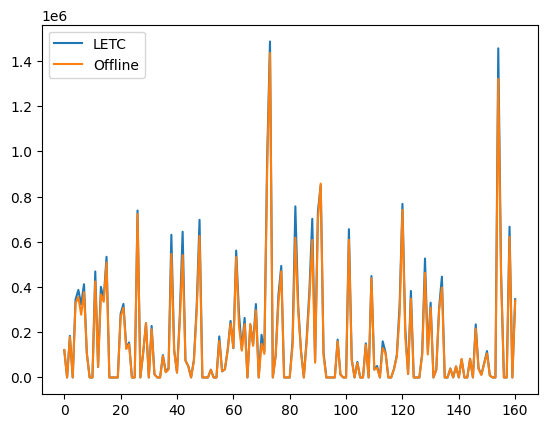

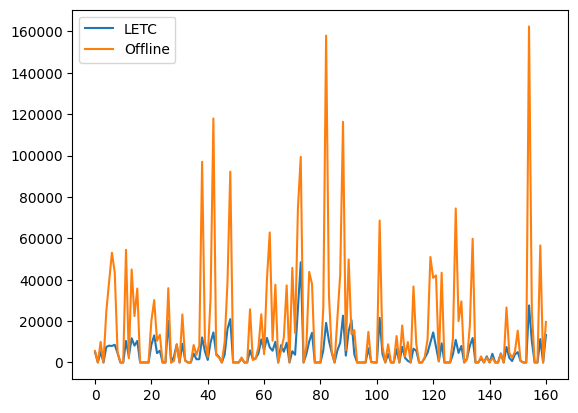

In [5]:
revenue_letc=np.loadtxt('revenue_letc.txt')
revenue_offline=np.loadtxt('revenue_offline.txt')
regret_letc=np.loadtxt('regret_letc.txt')
regret_offline=np.loadtxt('regret_offline.txt')

plt.plot(revenue_letc,label='LETC')
plt.plot(revenue_offline,label='Offline')
plt.legend()
plt.show()

plt.plot(regret_letc,label='LETC')
plt.plot(regret_offline,label='Offline')
plt.legend()
plt.show()

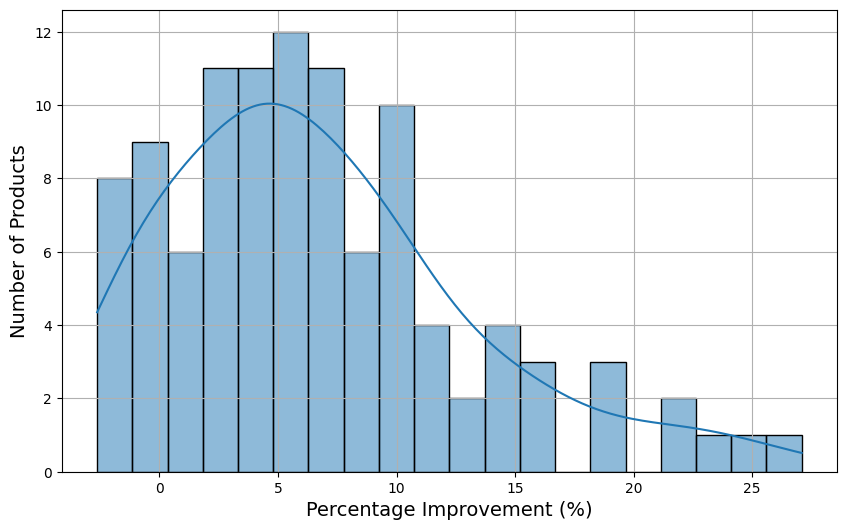

In [6]:
revenue_letc=[x for x in revenue_letc if x!= 0]
revenue_offline=[x for x in revenue_offline if x!= 0]
regret_letc=[x for x in regret_letc if x!= 0]
regret_offline=[x for x in regret_offline if x!= 0]
n_prod=len(revenue_letc)

improvement = [((revenue_letc[i] - revenue_offline[i]) / revenue_offline[i]) * 100 for i in range(n_prod)]
import seaborn as sns
# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(improvement, bins=20, kde=True)
#plt.title('Histogram of Revenue Improvement (LETC over offline policy)',fontsize=16)
plt.xlabel('Percentage Improvement (%)',fontsize=14)
plt.ylabel('Number of Products',fontsize=14)
plt.grid(True)
plt.savefig('improvement.pdf')
plt.show()

In [ ]:
n_prod, len(DP.prods)

(105, 228)